## Breast Cancer Detection Using Deep Learning Approaches

In [1]:
import opendatasets as od
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras.utils as image
import glob
import seaborn as sns

#### Load Dataset

In [2]:
dataset_url = "https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images"
od.download(dataset_url)

Skipping, found downloaded files in "./breast-histopathology-images" (use force=True to force download)


In [3]:
#Dataset directory
dataset_dir = "./breast-histopathology-images"
print(os.listdir(dataset_dir))

['9036', '10268', '10257', '8913', '13613', '8914', '15510', '10259', '16165', '10292', '12951', '10261', '10295', '9259', '12750', '13020', '16552', '12905', '9266', '16555', '13018', '9261', '9257', '12934', '12933', '9250', '10260', '10258', '10293', '9037', '10269', '16531', '10256', '15516', '12932', '12935', '9256', '16554', '9260', '13019', '16553', '13021', '8984', '9258', '12751', '9267', '12876', '12882', '15634', '12871', '14188', '15633', '9324', '12878', '9323', '9383', '8867', '9346', '9174', '12822', '9173', '9322', '9325', '12879', '14189', '12870', '12884', '12241', '15632', '12883', '12877', '9126', '13106', '12823', '13591', '9175', '12824', '9347', '9181', '9382', '10307', '13916', '10300', '14306', '15471', '16896', '14156', '9135', '12890', '12897', '10308', '10301', '10306', '12896', '14157', '12891', '12898', '14192', '13458', '9083', '9077', '13460', '8955', '12910', '9041', '14210', 'IDC_regular_ps50_idx5', '14082', '10274', '9227', '10273', '13402', '14078', 

In [4]:
#Number of the files in the dataset directory
files = os.listdir(dataset_dir)
print(len(files))

280


In [5]:
#Number of the patients
base_path = "./breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = os.listdir(base_path)
len(folder)

279

The patient ID is a component of the file name format, as stated in the dataset description. In light of this situation, we discovered that this dataset contains the data of 279 patients.

In [6]:
#Total number of the images in the dataset
total_img = 0
for patient_id in os.listdir(dataset_dir):
    patient_path = os.path.join(dataset_dir, patient_id)
    for c in [0, 1]:
        class_path = os.path.join(patient_path, str(c))
        if os.path.exists(class_path):
            total_img += len(os.listdir(class_path))
print(f"There are {total_img} images in the dataset.")

There are 277524 images in the dataset.


#### Data Preparation

For easier access to the dataset, we create a data frame that contains the components such as patient_id, path and target.

In [7]:
data = []

for patient_id in os.listdir(dataset_dir):
    patient_path = os.path.join(dataset_dir, patient_id)
    for label in [0, 1]:
        class_path = os.path.join(patient_path, str(label))
        if os.path.exists(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                # Extract x and y coordinates from the filename
                coords = img_file.split('_')[2:4]
                x_coord, y_coord = int(coords[0][1:]), int(coords[1][1:])
                # Append data to the list
                data.append({
                    'patient_id': patient_id,
                    'path': img_path,
                    'x_coord': x_coord,
                    'y_coord': y_coord,
                    'label': label,
                })

df = pd.DataFrame(data)
df

,patient_id,path,x_coord,y_coord,label
0,9036,./breast-histopathology-images/9036/0/9036_idx...,1051,2401,0
1,9036,./breast-histopathology-images/9036/0/9036_idx...,2951,951,0
2,9036,./breast-histopathology-images/9036/0/9036_idx...,3001,1451,0
3,9036,./breast-histopathology-images/9036/0/9036_idx...,3051,801,0
4,9036,./breast-histopathology-images/9036/0/9036_idx...,951,1901,0
...,...,...,...,...,...
277519,8957,./breast-histopathology-images/8957/1/8957_idx...,1951,701,1
277520,8957,./breast-histopathology-images/8957/1/8957_idx...,2051,551,1
277521,8957,./breast-histopathology-images/8957/1/8957_idx...,1951,651,1
277522,8957,./breast-histopathology-images/8957/1/8957_idx...,1451,551,1


In [8]:
df.shape

(277524, 5)

#### Data Visualisation

After creating the data frame for easy usage, it is time to take a look at the images of the dataset. 

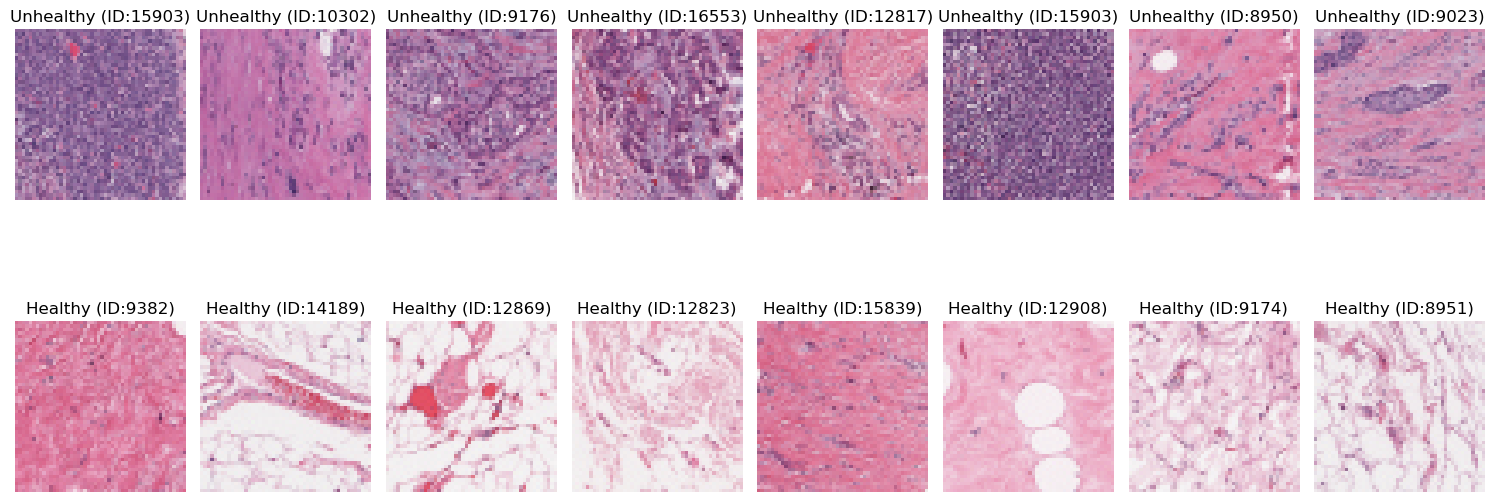

In [9]:
unhealthy_images = df[df['label'] == 1]
healthy_images = df[df['label'] == 0]

# Visualize random samples of images with the same x and y coordinates
num_images_to_display = 8
random_x_y_coordinates = unhealthy_images[['x_coord', 'y_coord']].sample(num_images_to_display)

fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 7))

for i, (index, row) in enumerate(random_x_y_coordinates.iterrows()):
    x_coord = row['x_coord']
    y_coord = row['y_coord']
    
    # Select unhealthy image with the same x and y coordinates
    unhealthy_img_row = unhealthy_images[(unhealthy_images['x_coord'] == x_coord) & (unhealthy_images['y_coord'] == y_coord)].sample(1)
    unhealthy_img_path = unhealthy_img_row['path'].iloc[0]
    unhealthy_img = mpimg.imread(unhealthy_img_path)
    
    # Select healthy image with the same x and y coordinates
    healthy_img_row = healthy_images[(healthy_images['x_coord'] == x_coord) & (healthy_images['y_coord'] == y_coord)].sample(1)
    healthy_img_path = healthy_img_row['path'].iloc[0]
    healthy_img = mpimg.imread(healthy_img_path)
    
    axes[0, i].imshow(unhealthy_img)
    axes[0, i].set_title(f"Unhealthy (ID:{unhealthy_img_row['patient_id'].iloc[0]})")
    axes[0, i].axis('off')
    axes[1, i].imshow(healthy_img)
    axes[1, i].set_title(f"Healthy (ID:{healthy_img_row['patient_id'].iloc[0]})")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

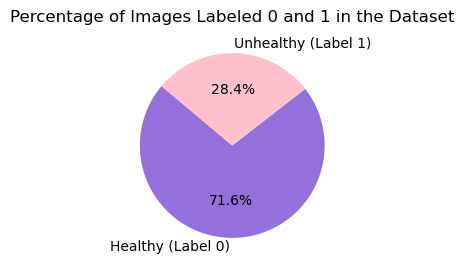

In [10]:
label_counts = df['label'].value_counts()
colors = ['#9370DB', '#FFC0CB']
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=['Healthy (Label 0)', 'Unhealthy (Label 1)'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Images Labeled 0 and 1 in the Dataset')
plt.show()

<Figure size 1200x600 with 0 Axes>

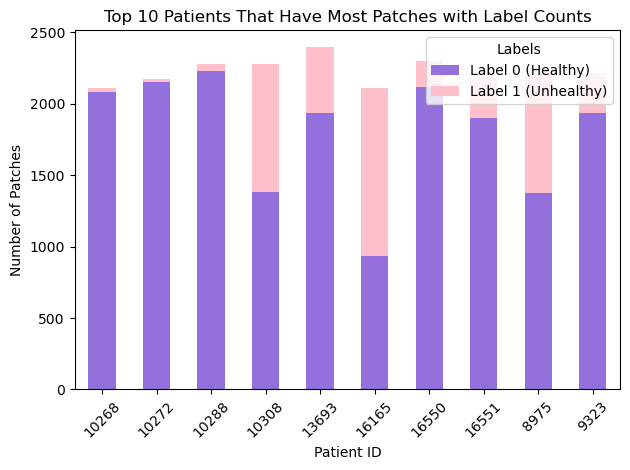

In [11]:
patches_per_patient = df['patient_id'].value_counts()
top_patients = patches_per_patient.head(10)
top_patients_df = df[df['patient_id'].isin(top_patients.index)]

# Group the data by patient ID and label, and count the occurrences
grouped_data = top_patients_df.groupby(['patient_id', 'label']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
grouped_data.plot(kind='bar', stacked=True, color=['#9370DB', '#FFC0CB'])
plt.title('Top 10 Patients That Have Most Patches with Label Counts')
plt.xlabel('Patient ID')
plt.ylabel('Number of Patches')
plt.xticks(rotation=45)
plt.legend(title='Labels', labels=['Label 0 (Healthy)', 'Label 1 (Unhealthy)'], loc='upper right')
plt.tight_layout()
plt.show()

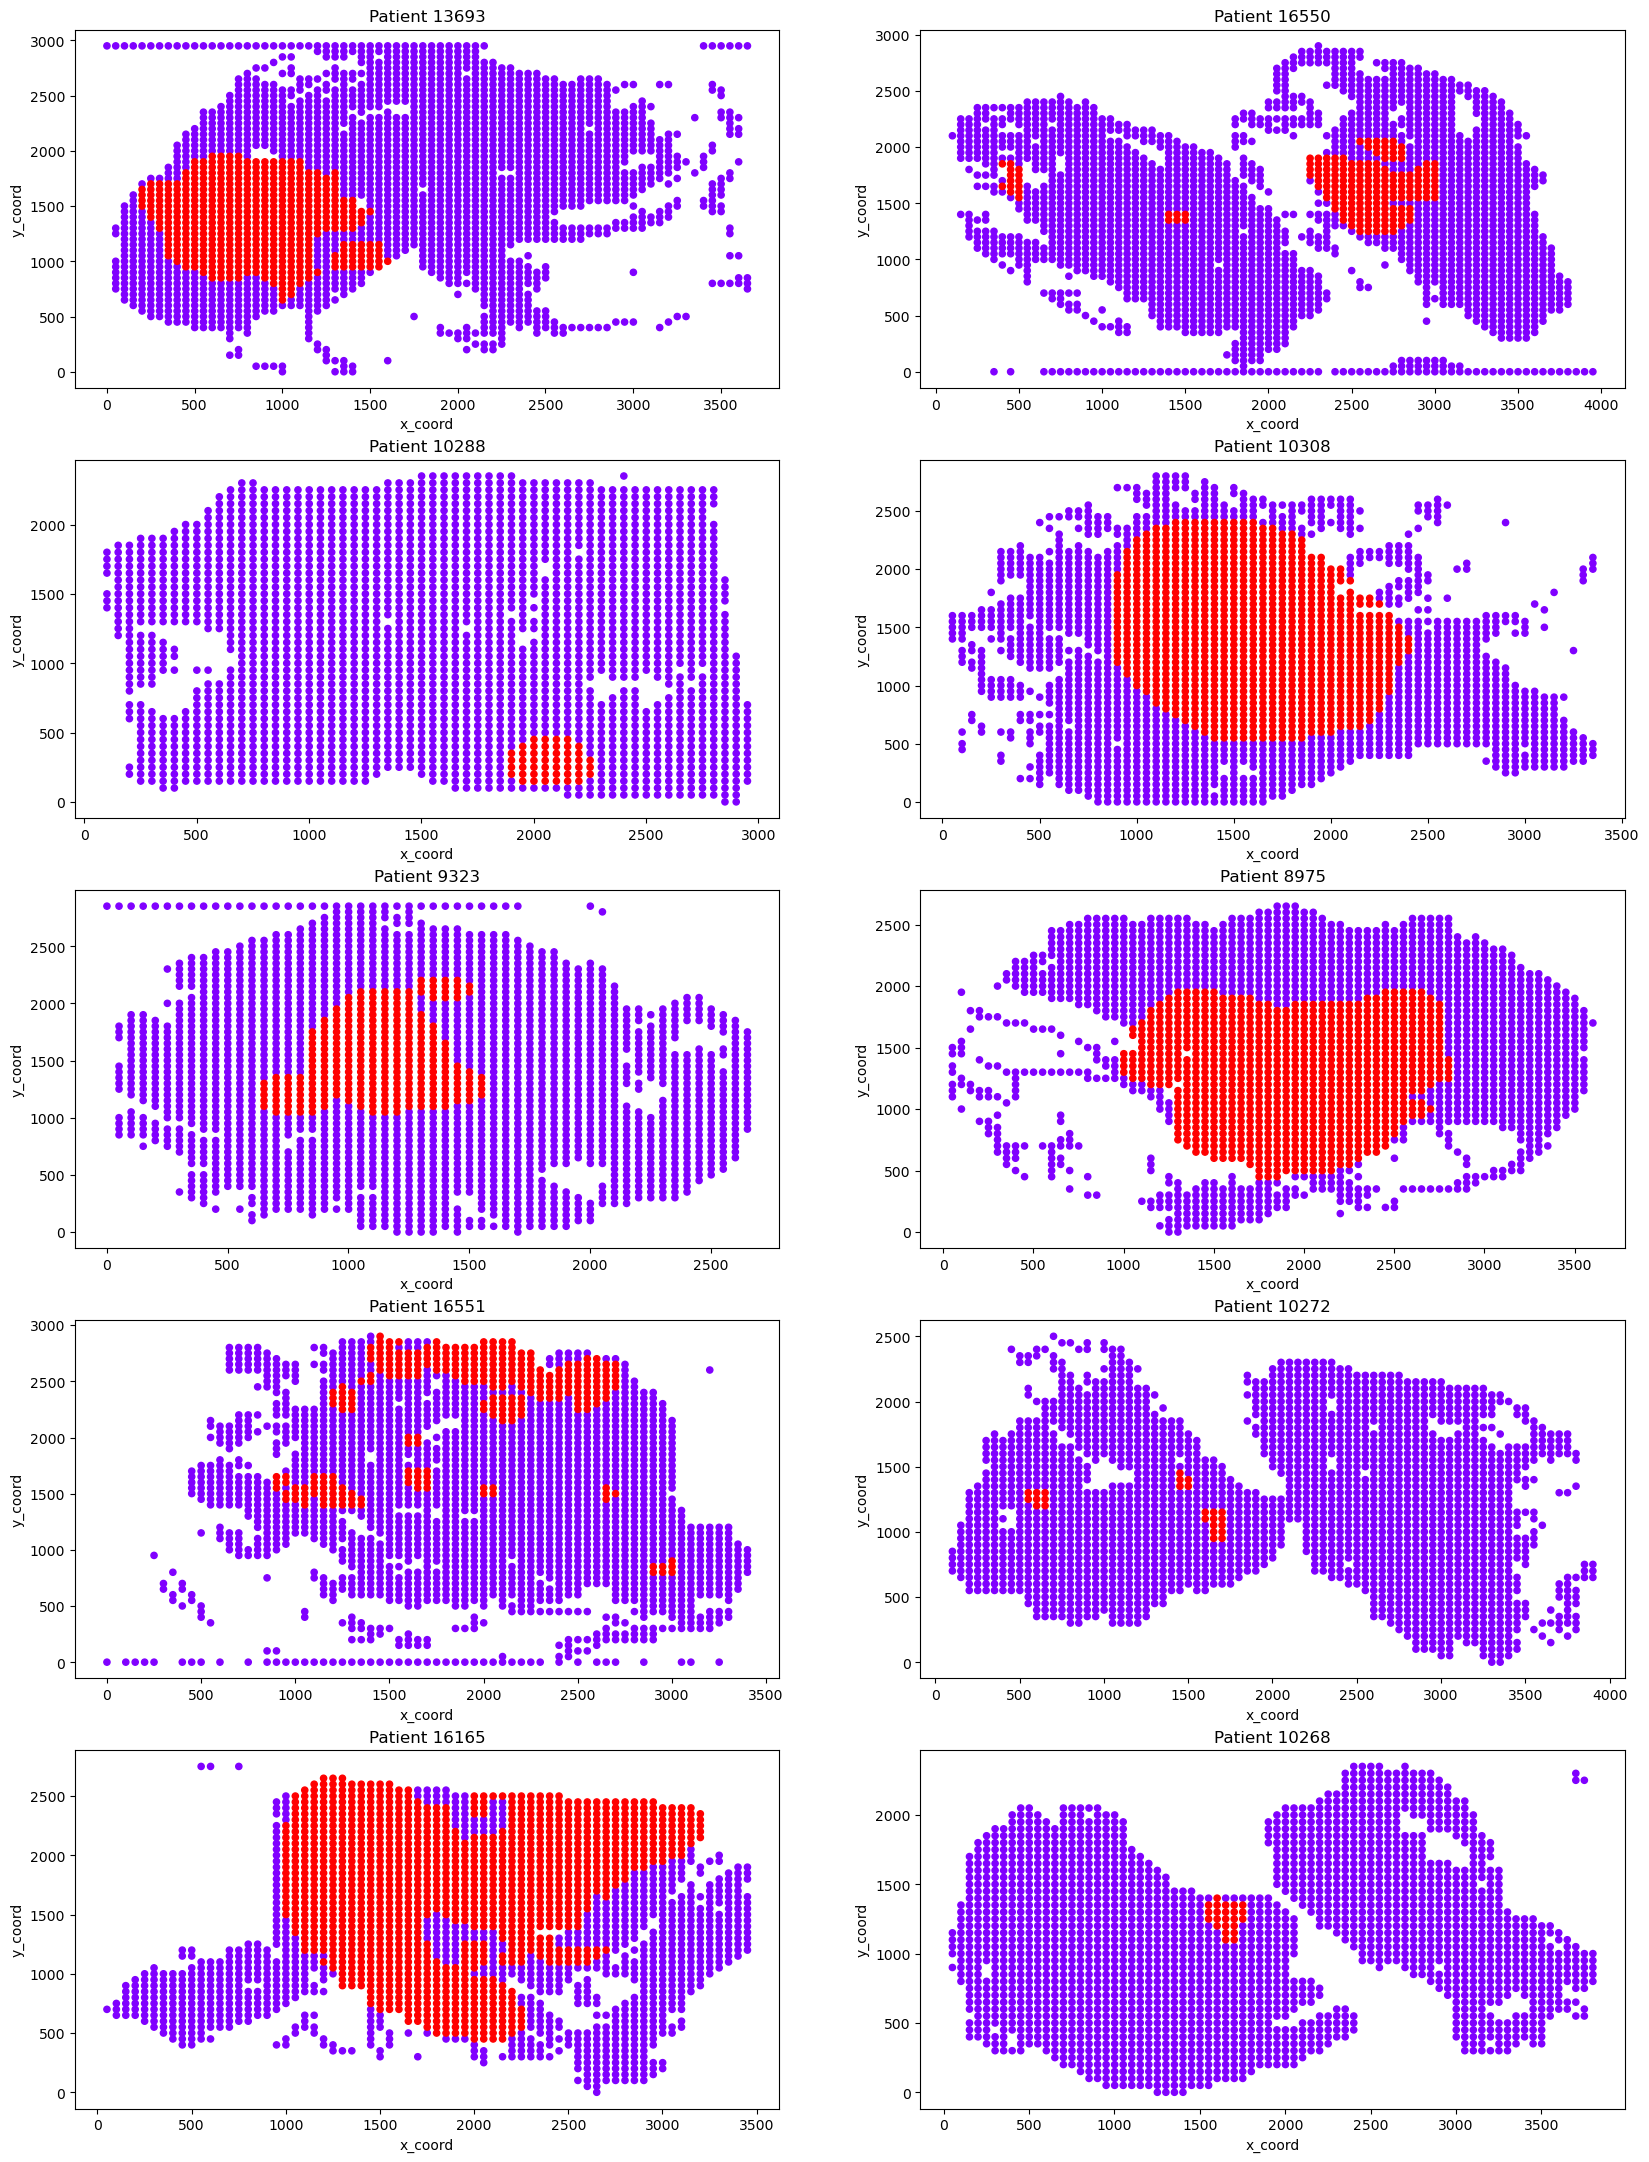

In [15]:
#Binary Label Visualisation

patches_per_patient = df['patient_id'].value_counts()
top_patients = patches_per_patient.head(10).index.tolist()

fig, ax = plt.subplots(5, 2, figsize=(20, 27))

for i, patient_id in enumerate(top_patients):
    n = i // 2
    m = i % 2
    
    binary_df = df[df['patient_id'] == patient_id]
    ax[n, m].scatter(binary_df['x_coord'], binary_df['y_coord'], c=binary_df['label'], cmap="rainbow", s=20)
    ax[n, m].set_title("Patient " + patient_id)
    ax[n, m].set_xlabel("x_coord")
    ax[n, m].set_ylabel("y_coord")

plt.show()